# Santa Ana Winds Notebook

Santa Ana winds are intense dry winds that blow from the Mojave Desert downslope to the Southern California coast (Seto et al. 2025). Upper level temperature and winds, along with the gradient in sea level pressure, can be used to identify conditions that support Santa Ana Wind occurence. 

**Intended Application:** As a user, I want to generate timeseries of key Santa Ana Wind indicators.

**Runtime:** On the Analytics Engine Jupyter Hub platform this notebook will take approximately 30 minutes to run.

**References:**


Seto, D., C. Jones, D. Siuta, N. Wagenbrenner, C. Thompson, and N. Quinn, 2025: Evaluation of HRRR Wind Speed Forecast and WindNinja Downscaling Accuracy during Santa Ana Wind Events in Southern California. Wea. Forecasting, 40, 525–541, https://doi.org/10.1175/WAF-D-24-0013.1. 

In [1]:
# TODO: delete in final version
%load_ext autoreload
%autoreload 2

In [2]:
from climakitae.core.constants import WRF_CRS
from climakitae.core.data_export import export
from climakitae.new_core.processors.warming_level import WarmingLevel
from climakitae.util.utils import add_dummy_time_to_wl, get_closest_gridcell
from climakitae.tools.derived_variables import (
    compute_wind_dir,
    compute_sea_level_pressure,
)
import geostrophic_wind as geo_wind

import geopandas as gpd
import numpy as np
import pyproj
from pyproj import CRS, Geod, Proj
import s3fs
from shapely.geometry import box, mapping, LineString
import xarray as xr
import matplotlib.pyplot as plt

# Setup

### Choose points
The value at `gradient_point_2` will be subtracted from the value at `gradient_point_1`.

In [3]:
gradient_point_1 = (34.031899244954694, -118.47507877286985)  # Santa Monica
gradient_point_2 = (34.31392420709518, -116.16003299789273)  # Mojave Desert

### Choose global warming Levels

In [4]:
baseline_gwl = 0.8
future_gwl = 2.0

# Temperature and Geostrophic Wind

Runtime: 11 minutes

## 1. Get Warming Levels

Access the WRF data for temperature and geopotential height.

In [5]:
import time

start = time.time()
hist_path = "s3://santa-ana-winds/miroc6_r1i1p1f1_historical/d01/temperature_geopotential_plevs.zarr"
ssp370_path = "s3://santa-ana-winds/miroc6_r1i1p1f1_ssp370/d01/temperature_geopotential_plevs.zarr/"

ds_hist = xr.open_dataset(
    hist_path, consolidated=True, zarr_format=2, engine="zarr", chunks={}
)
ds_ssp370 = xr.open_dataset(
    ssp370_path, consolidated=True, zarr_format=2, engine="zarr", chunks={}
)

ds_hist = ds_hist.sel(time=slice("1980-09-01", "2014-08-31 13:00"))
ds_ssp370 = ds_ssp370.sel(time=slice("2014-08-31 14:00", "2066-08-04 13:00"))

ds_hist = ds_hist.expand_dims({"member_id": ["r1i1p1f1"]})
ds_ssp370 = ds_ssp370.expand_dims({"member_id": ["r1i1p1f1"]})

ds_hist = ds_hist.convert_calendar("noleap")
ds_ssp370 = ds_ssp370.convert_calendar("noleap")

Get the warming levels.

In [8]:
values = {
    "warming_levels": [baseline_gwl, future_gwl],
    "warming_level_months": [x for x in range(1, 13)],
}
WL = WarmingLevel(values)

data = {}
data["WRF.UCLA.MIROC6.ssp370.1hr.d03"] = ds_ssp370
data["WRF.UCLA.MIROC6.historical.1hr.d03"] = ds_hist
context = {"activity_id": "WRF"}
wls = WL.execute(data, context)

ds_wl = wls["WRF.UCLA.MIROC6.ssp370.1hr.d03.r1i1p1f1"]

ds_wl.attrs["frequency"] = "1hr"
ds_wl = add_dummy_time_to_wl(ds_wl)
ds_wl = ds_wl.expand_dims("sim", axis=0)
ds_wl = ds_wl.assign_coords(
    {"sim": ["WRF.UCLA.MIROC6.ssp370.1hr.d03.r1i1p1f1".replace(".", "_")]}
)

## 3. Temperature gradient

Find the upper level temperature at the two points of interest and get the difference. Choose a pressure level (the `level` variable) and run the cell below to calculate this difference and write the result to file.

In [10]:
# Pick a pressure level to display and export.
# Valid levels are 1000, 925, 850, 700, 500, 300, or 200.
level = 850

# Get the temperature difference at this level
print("Getting temperature at each point.")
temperature = ds_wl["temperature"].sel(pressure_level=level)

temp_pt_1 = get_closest_gridcell(
    temperature, gradient_point_1[0], gradient_point_1[1]
).compute()
temp_pt_2 = get_closest_gridcell(
    temperature, gradient_point_2[0], gradient_point_2[1]
).compute()

print("Calculating difference.")
temperature_diff = temp_pt_1 - temp_pt_2
temperature_diff.name = "temperature_gradient"
temperature_diff.attrs["long_name"] = "Temperature Gradient on Pressure Level"

print("Write results to file.")
# Export hourly data
export(
    temperature_diff,
    f"temperature_gradient_{level}hPa.nc",
    format="NetCDF",
    mode="local",
)

Getting temperature at each point.
Closest gridcell to lat: 34.031899244954694, lon: -118.47507877286985 is at lat: 34.03968811035156, lon: -118.3582763671875
Closest gridcell to lat: 34.31392420709518, lon: -116.16003299789273 is at lat: 34.27177429199219, lon: -116.15371704101562
Calculating difference.
Write results to file.
Exporting specified data to NetCDF...
Saving file locally as NetCDF4...
[########################################] | 100% Completed | 101.18 ms
Saved! You can find your file in the panel to the left and download to your local machine from there.


This figure shows the temperature gradient at the selected level for each warming level.

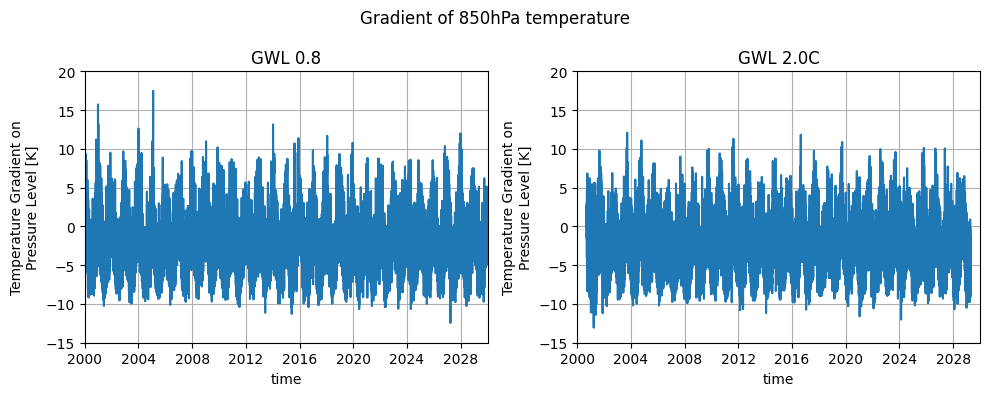

In [11]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.rcParams.update(
    {
        "grid.color": "0.5",  # gray gridlines
        "grid.linestyle": "--",  # solid gridlines
        "grid.linewidth": 0.5,  # thin gridlines
    }
)


temperature_diff.sel(warming_level=baseline_gwl).plot(ax=ax[0])
ax[0].set_title(f"GWL {baseline_gwl}")
ax[0].set_ylim([-15, 20])
ax[0].set_xlim([temperature_diff.time[0].data, temperature_diff.time[-1].data])
ax[0].grid(True)

temperature_diff.sel(warming_level=future_gwl).plot(ax=ax[1])
ax[1].set_title(f"GWL {future_gwl}C")
ax[1].set_ylim([-15, 20])
ax[1].set_xlim([temperature_diff.time[0].data, temperature_diff.time[-1].data])
ax[1].grid(True)

plt.suptitle(f"Gradient of {level}hPa temperature")
plt.tight_layout()
plt.savefig(f"temperature_gradient_{level}hPa_by_gwl.png")

In [12]:
del temp_pt_1, temp_pt_2, temperature_diff

## 4. Wind on Pressure Levels
In this section we use the geostrophic wind equation to calculate the upper level wind on pressure levels at a point in between the two points of interest.

Timing: this section takes approximately 20 minutes

After choosing a pressure level (the `level` variable below), run this cell to calculate the upper level wind at your level.

In [ ]:
# Select a pressure level before computing the magnitude and direction of the geostrophic wind.
# Valid levels are 1000, 925, 850, 700, 500, 300, or 200. The default value is 850 hPa.
level = 850

# The geostrophic wind will be calculated for each point for the selected level.
for point_ind, point in enumerate([gradient_point_1, gradient_point_2]):
    print(f"Working on point {point_ind+1}")
    # Need to work with a smaller area for geostrophic wind calculation
    # so creating a box around our area of interest.
    corner_ur = (point[0] + 1, point[1] - 1)  # upper right
    corner_ll = (point[0] - 1, point[1] + 1)  # lower left

    geom = gpd.GeoDataFrame(
        geometry=[
            box(
                minx=corner_ll[1],
                miny=corner_ll[0],
                maxx=corner_ur[1],
                maxy=corner_ur[0],
            )
        ],
        crs=pyproj.CRS.from_epsg(4326),
    )
    ds_wl_clipped = ds_wl.rio.clip(
        geom.geometry.apply(mapping),
        geom.crs,
        drop=True,
        all_touched=True,
    ).rio.write_crs(ds_wl.rio.crs)

    # Then the geostrophic wind is calculated for a point in between the points of interest. This will take several minutes.
    print("Calculating geostrophic wind.")
    geopotential_height = ds_wl_clipped["geopotential_height"].sel(pressure_level=level)

    # Get the geostrophic wind components at this point
    geo_wind_u_earth, geo_wind_v_earth = geo_wind.geostrophic_wind_single_point(
        geopotential_height, point
    )

    print("Calculating magnitude and direction.")

    # Extract 'level' from wind datasets
    geo_u_level = geo_wind_u_earth.compute()
    geo_v_level = geo_wind_v_earth.compute()

    # Magnitude
    magnitude = np.sqrt(geo_u_level**2 + geo_v_level**2)
    magnitude.name = "magnitude"
    magnitude.attrs["long_name"] = "Geostrophic Wind Magnitude"
    magnitude.attrs["units"] = "m/s"

    # Direction
    direction = compute_wind_dir(geo_u_level, geo_v_level)
    direction.name = "wind_direction"
    direction.attrs["long_name"] = "Geostrophic Wind Direction"
    print(direction)
    # Don't need to add units manually; units were added by compute_wind_dir

    # Export the timeseries for this level to file. Using the default settings, each of these files is
    # approximately 4.2 Mb in size (30 years of hourly data for two warming levels).
    export(
        magnitude,
        f"geostrophic_wind_mag_{level}hPa_point_{point_ind+1}.nc",
        format="NetCDF",
        mode="local",
    )
    export(
        direction,
        f"geostrophic_wind_dir_{level}hPa_point_{point_ind+1}.nc",
        format="NetCDF",
        mode="local",
    )
    print("\n")

print(f"Calculating mean wind magnitude at {level} hPa.")
magnitude_1 = xr.open_dataset(f"geostrophic_wind_mag_{level}hPa_point_1.nc")
magnitude_2 = xr.open_dataset(f"geostrophic_wind_mag_{level}hPa_point_2.nc")
magnitude_mean = (magnitude_1 + magnitude_2) / 2
export(
    magnitude_mean,
    f"geostrophic_wind_dir_{level}hPa_point_mean.nc",
    format="NetCDF",
    mode="local",
)

print("Done")

Working on point 1
Calculating geostrophic wind.


Optionally, this code can be used to visualize the upper level wind results.

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.rcParams.update(
    {
        "grid.color": "0.5",  # gray gridlines
        "grid.linestyle": "--",  # solid gridlines
        "grid.linewidth": 0.5,  # thin gridlines
    }
)


magnitude = xr.open_dataset(f"geostrophic_wind_dir_{level}hPa_point_mean.nc")
magnitude["magnitude"].sel(warming_level=baseline_gwl).plot(ax=ax[0])
ax[0].set_title(f"GWL {baseline_gwl}")
ax[0].set_ylim([0, 70])
ax[0].set_xlim([magnitude.time[0].data, magnitude.time[-1].data])
ax[0].grid(True)

magnitude["magnitude"].sel(warming_level=future_gwl).plot(ax=ax[1])
ax[1].set_title(f"GWL {future_gwl}C")
ax[1].set_ylim([0, 70])
ax[1].set_xlim([magnitude.time[0].data, magnitude.time[-1].data])
ax[1].grid(True)

plt.suptitle(f"Point mean {level}hPa wind magnitude")
plt.tight_layout()
plt.savefig(f"mean_magnitude_{level}hPa_by_gwl.png")

In [ ]:
direction = xr.open_dataset(f"geostrophic_wind_dir_{level}hPa_point_1.nc")
f, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.rcParams.update(
    {
        "grid.color": "0.5",  # gray gridlines
        "grid.linestyle": "--",  # solid gridlines
        "grid.linewidth": 0.5,  # thin gridlines
    }
)

direction["wind_direction"].sel(warming_level=baseline_gwl).plot(ax=ax[0])
ax[0].set_title(f"GWL {baseline_gwl}")
ax[0].set_ylim([0, 70])
ax[0].set_xlim([magnitude.time[365 * 24].data, magnitude.time[365 * 24 * 2].data])
ax[0].grid(True)

direction["wind_direction"].sel(warming_level=future_gwl).plot(ax=ax[1])
ax[1].set_title(f"GWL {future_gwl}C")
ax[1].set_ylim([0, 70])
ax[1].set_xlim([magnitude.time[365 * 24].data, magnitude.time[365 * 24 * 2].data])
ax[1].grid(True)

plt.suptitle(f"Point 1 {level}hPa wind direction")
plt.tight_layout()
plt.savefig(f"point_1_direction_{level}hPa_by_gwl.png")

# Sea Level Pressure

Sea level is computed using surface pressure, air temperature, and mixing ratio. Then the difference between two points is calculated and saved to file.

### Setup
Choose the time frequency in the cell below. This section will use the warming levels and locations selected in the "Setup" section at the top of the notebook.

In [ ]:
frequency = "1hr"  # 1hr or day

This function will handle the sea level pressure calculation for the selection gridpoints.

In [ ]:
def get_slp_at_point(
    psfc: xr.DataArray,
    t2: xr.DataArray,
    q2: xr.DataArray,
    elevation: xr.DataArray,
    point: tuple[float],
) -> xr.DataArray:
    """Extract point of interest and return sea level pressure at that point.

    This function uses the default settings for `compute_sea_level_pressure`
    including for lapse rate.

    Parameters
    ----------
        surface_pressure : xr.DataArray
            Surface pressure in Pascals
        air_temperature : xr.DataArray
            Surface air temperature in Kelvin
        mixing_ratio : xr.DataArray
            Surface mixing ratio
        elevation : xr.DataArray
            Elevation in meters

    Returns
    -------
    xr.DataArray
        Sea level pressure in Hectopascals
    """

    # Extract data at point of interest
    psfc_pt = get_closest_gridcell(psfc.rio.write_crs(WRF_CRS), point[0], point[1])
    t2_pt = get_closest_gridcell(t2.rio.write_crs(WRF_CRS), point[0], point[1])
    q2_pt = get_closest_gridcell(q2.rio.write_crs(WRF_CRS), point[0], point[1])
    elev_pt = get_closest_gridcell(elevation.rio.write_crs(WRF_CRS), point[0], point[1])

    if frequency == "1hr":
        slp_pt = compute_sea_level_pressure(psfc_pt, t2_pt, q2_pt, elev_pt)
        slp_pt.attrs["frequency"] = "hourly"
    else:
        slp_pt = compute_sea_level_pressure(
            psfc_pt, t2_pt, q2_pt, elev_pt, average_t2=False
        )
        slp_pt.attrs["frequency"] = "daily"

    # Convert to hPa
    slp_pt = slp_pt / 100.0
    slp_pt.attrs["units"] = "hPa"

    # Add dummy time axis
    slp_pt = add_dummy_time_to_wl(slp_pt)

    return slp_pt

Access the three variables (surface pressure, air temperature, and mixing ratio) we need to get sea level pressure. Results are clipped to the two points of interest. This cell will take several minutes to run.

In [ ]:
import climakitae as ck

cd = ck.ClimateData(verbosity=-1)

# Surface pressure
psfc = (
    cd.catalog("cadcat")
    .activity_id("WRF")
    .institution_id("UCLA")
    .table_id(frequency)
    .grid_label("d03")
    .variable("psfc")
    .processes(
        {
            "clip": [gradient_point_1, gradient_point_2],
            "warming_level": {
                "warming_levels": [baseline_gwl, future_gwl],
                "warming_level_window": 5,  # TODO: normal window in final version
            },
        }
    )
    .get()
)

# Air temperature
t2 = (
    cd.catalog("cadcat")
    .activity_id("WRF")
    .institution_id("UCLA")
    .table_id(frequency)
    .grid_label("d03")
    .variable("t2")
    .processes(
        {
            "clip": [gradient_point_1, gradient_point_2],
            "warming_level": {
                "warming_levels": [baseline_gwl, future_gwl],
                "warming_level_window": 5,
            },
        }
    )
    .get()
)

# Mixing ratio
q2 = (
    cd.catalog("cadcat")
    .activity_id("WRF")
    .institution_id("UCLA")
    .table_id(frequency)
    .grid_label("d03")
    .variable("q2")
    .processes(
        {
            "clip": [gradient_point_1, gradient_point_2],
            "warming_level": {
                "warming_levels": [baseline_gwl, future_gwl],
                "warming_level_window": 5,
            },
        }
    )
    .get()
)

Get the elevation data for the d03 grid.

In [ ]:
fs = s3fs.S3FileSystem(anon=True)
elevation_url = "s3://cadcat/wrf/cae/elevation_wrf.nc"
elevation = xr.open_dataset(fs.open(elevation_url), engine="h5netcdf")

Calculate the sea level pressure at each point and get the difference.

In [ ]:
# Get SLP at points
slp_pt_1 = get_slp_at_point(
    psfc["psfc"], t2["t2"], q2["q2"], elevation["elevation"], gradient_point_1
).compute()
slp_pt_2 = get_slp_at_point(
    psfc["psfc"], t2["t2"], q2["q2"], elevation["elevation"], gradient_point_2
).compute()

# Get difference
slp_dif = slp_pt_1 - slp_pt_2

# Convert to dataset with name "slp_gradient"
slp_ds = slp_dif.to_dataset(name="slp_gradient")

export(slp_ds, "slp_gradient.nc", format="NetCDF", mode="local")

This figure demonstrates the resulting gradient for a single model for one year from the baseline warming level.

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
plt.rcParams.update(
    {
        "grid.color": "0.5",  # gray gridlines
        "grid.linestyle": "--",  # solid gridlines
        "grid.linewidth": 0.5,  # thin gridlines
    }
)


slp_ds["slp_gradient"].sel(
    warming_level=baseline_gwl, sim="WRF_UCLA_MIROC6_ssp370_1hr_d03_r1i1p1f1"
).plot(ax=ax[0])
ax[0].set_title(f"GWL {baseline_gwl}")
# ax[0].set_ylim([0, 70])
ax[0].set_xlim([slp_ds.time[0].data, slp_ds.time[-1].data])
ax[0].grid(True)

slp_ds["slp_gradient"].sel(
    warming_level=future_gwl, sim="WRF_UCLA_MIROC6_ssp370_1hr_d03_r1i1p1f1"
).plot(ax=ax[1])
ax[1].set_title(f"GWL {future_gwl}C")
# ax[1].set_ylim([0, 70])
ax[1].set_xlim([slp_ds.time[0].data, slp_ds.time[-1].data])
ax[1].grid(True)

plt.suptitle(f"Sea level pressure gradient\nWRF_UCLA_MIROC6_ssp370_1hr_d03_r1i1p1f1")
plt.tight_layout()
plt.savefig(f"slp_gradient_by_gwl_WRF_UCLA_MIROC6_ssp370_1hr_d03_r1i1p1f1.png")